# Task 

## Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Данные находятся в файле /datasets/autos.csv. 
Признаки
 - DateCrawled — дата скачивания анкеты из базы
 - VehicleType — тип автомобильного кузова
 - RegistrationYear — год регистрации автомобиля
 - Gearbox — тип коробки передач
 - Power — мощность (л. с.)
 - Model — модель автомобиля
 - Kilometer — пробег (км)
 - RegistrationMonth — месяц регистрации автомобиля
 - FuelType — тип топлива
 - Brand — марка автомобиля
 - Repaired — была машина в ремонте или нет
 - DateCreated — дата создания анкеты
 - NumberOfPictures — количество фотографий автомобиля
 - PostalCode — почтовый индекс владельца анкеты (пользователя)
 - LastSeen — дата последней активности пользователя

Целевой признак
 - Price — цена (евро)

# Libs import

In [1]:
# Загрузим нужные библиотеки
try:
    import phik
except ModuleNotFoundError:
    ! pip install phik -q
    import phik

In [2]:
try:
    import shap
except ModuleNotFoundError:
    ! pip install shap -q
    import shap

c:\Users\l.olipa\practicum\practicum_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.5.0.


In [4]:
# стандартные библиотеки
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
import time
from scipy import stats as st
from IPython.display import display
from scipy.stats import randint

# загружаем нужные модели Регрессии
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler,
    LabelEncoder)

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# импортируем классы для перебора параметров 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, confusion_matrix, make_scorer, root_mean_squared_error, mean_squared_error

# загружаем класс pipeline
from sklearn.pipeline import Pipeline


# загружаем инструменты для анализа DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from shap import TreeExplainer

# загрузим дамми-модели
from sklearn.dummy import DummyRegressor

# Describing function

In [5]:
# Писал сам, улучшал с помощью chatGPT
def df_uni_describe(df: pd.DataFrame) -> None:
    """
    Universal function for describing a pandas DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame to be described.

    This function provides a comprehensive description of the DataFrame including:
    - Main info: Number of variables, number of observations, total missing values, and total duplicates.
    - Missing (NaNs) percentage per column if any.
    - Info of the DataFrame including data types and memory usage.
    - Head of the DataFrame.
    - Descriptive statistics for numerical columns.
    """
    try:
        # Main info
        print("\033[1m" + 'Main info:' + "\033[0m")
        print(f"Number of variables: {df.shape[1]}")
        print(f"Number of observations: {df.shape[0]}")
        
        missing_percentage = df.isna().mean().round(4) * 100
        total_missing = missing_percentage.mean()
        print(f'Total missing: {total_missing:.2f}%')
        print(f'Total duplicates: {df.duplicated().sum()}')

        # Missing values
        if total_missing > 0:
            print("\033[1m" + 'Missing (NaNs), %' + "\033[0m")
            display(missing_percentage.to_frame('NaNs, %').sort_values(by='NaNs, %', ascending=False).style.background_gradient('coolwarm'))

        # Info of dataframe
        print("\033[1m" + 'Info of dataframe:' + "\033[0m")
        df.info()

        # Head of dataframe
        print("\033[1m" + 'Head of dataframe:' + "\033[0m")
        display(df.head(2))

        # Descriptive statistics
        print("\033[1m" + 'Descriptive statistics:' + "\033[0m")
        display(df.describe().T)

    except Exception as e:
        print(f'An error occurred: {e}')

In [6]:
def show_box_hist(col: pd.Series, bins: int = None, show_hist: bool = True, show_boxplot: bool = True) -> dict:
    """
    Plots histogram and boxplot for a given quantitative parameter.

    Parameters:
    - col (pd.Series): Quantitative parameter for analysis.
    - bins (int or sequence, optional): Number of bins for the histogram (default is determined automatically).
    - show_hist (bool, optional): Whether to show histogram (default is True).
    - show_boxplot (bool, optional): Whether to show boxplot (default is True).
    
    Returns:
    - dict: Dictionary with descriptive statistics.
    """
    try:
        # Descriptive statistics
        description = col.describe().to_dict()
        print(f'Description of the column {col.name}:')
        display(pd.DataFrame(description, index=[0]))

        # Determine the layout for the plot
        if show_hist and show_boxplot:
            fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
        elif show_hist or show_boxplot:
            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 4))
            axs = [axs]  # Ensure axs is iterable as a list
        else:
            print("Both show_hist and show_boxplot are set to False. Nothing to plot.")
            return description

        # Plot histogram
        if show_hist:
            if bins is None:
                bins = 'auto'
            sns.histplot(col, bins=bins, kde=False, ax=axs[0] if show_boxplot else axs[0], color='skyblue')
            axs[0].set_title('Histogram')
            axs[0].set_xlabel(col.name)
            axs[0].set_ylabel('Frequency')

        # Plot boxplot
        if show_boxplot:
            sns.boxplot(x=col, ax=axs[1] if show_hist else axs[0], color='salmon')
            axs[1 if show_hist else 0].set_title('Boxplot')
            axs[1 if show_hist else 0].set_xlabel(col.name)

        plt.tight_layout()
        plt.show()
        
        return description

    except Exception as e:
        print(f'An error occurred: {e}')
        return {}

In [7]:
def cat_col_pie(col: pd.Series, top_n: int = 10):
    """
    Plots pie and bar charts for a given categorical parameter.
    Aggregates all categories beyond the top_n into 'Other'.

    Parameters:
    - col (pd.Series): Categorical parameter for analysis.
    - top_n (int, optional): Number of top categories to display (default is 10).
    
    Returns:
    - dict: Dictionary with counts and proportions of the categories.
    """
    try:
        # Calculate counts and proportions
        value_counts = col.value_counts()
        proportions = value_counts / value_counts.sum()

        # Aggregate the rest into "Other"
        if len(value_counts) > top_n:
            top_values = value_counts.iloc[:top_n]
            other_values = value_counts.iloc[top_n:].sum()
            top_values['Other'] = other_values
            
            top_proportions = proportions.iloc[:top_n]
            other_proportions = proportions.iloc[top_n:].sum()
            top_proportions['Other'] = other_proportions
        else:
            top_values = value_counts
            top_proportions = proportions

        # Display counts and proportions
        print(f'Counts and proportions in column {col.name}:')
        display(pd.DataFrame({
            'Counts': top_values,
            'Proportions': top_proportions
        }).style.format({
            'Proportions': '{:.2%}'
        }))

        # Plot pie chart
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
        fig.suptitle(f'Category Distribution in {col.name}')

        top_proportions.plot(kind='pie', ax=axes[0], autopct="%.1f%%", labels=top_proportions.index)
        axes[0].set_title('Pie Chart')
        axes[0].set_ylabel('')

        # Plot bar chart
        top_values.sort_values(ascending=True).plot(kind='barh', ax=axes[1], color='skyblue')
        axes[1].set_title('Bar Chart')
        axes[1].set_xlabel('Counts')

        plt.tight_layout()
        plt.show()
        
        return {
            'Counts': top_values.to_dict(),
            'Proportions': top_proportions.to_dict()
        }

    except Exception as e:
        print(f'An error occurred: {e}')
        return {}

# Load data

In [8]:
pth1 = '/datasets/autos.csv'
pth2 = 'datasets\\autos.csv'

if os.path.exists(pth1):
    df = pd.read_csv('datasets\\autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
elif os.path.exists(pth2):
    df = pd.read_csv('datasets\\autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
else:
    print('Something is wrong')

df_uni_describe(df)

Main info:
Number of variables: 16
Number of observations: 354369
Total missing: 3.19%
Total duplicates: 4
Missing (NaNs), %


,"NaNs, %"
Repaired,20.080000
VehicleType,10.580000
FuelType,9.280000
Gearbox,5.600000
Model,5.560000
DateCrawled,0.000000
Price,0.000000
RegistrationYear,0.000000
Power,0.000000
Kilometer,0.000000


Info of dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50


Descriptive statistics:


,count,mean,min,25%,50%,75%,max,std
DateCrawled,354369,2016-03-21 12:58:10.450648320,2016-03-05 14:06:22,2016-03-13 11:52:33,2016-03-21 17:50:55,2016-03-29 14:37:20,2016-04-07 14:36:58,NaN
Price,354369.0,4416.656776,0.0,1050.0,2700.0,6400.0,20000.0,4514.158514
RegistrationYear,354369.0,2004.234448,1000.0,1999.0,2003.0,2008.0,9999.0,90.227958
Power,354369.0,110.094337,0.0,69.0,105.0,143.0,20000.0,189.850405
Kilometer,354369.0,128211.172535,5000.0,125000.0,150000.0,150000.0,150000.0,37905.34153
RegistrationMonth,354369.0,5.714645,0.0,3.0,6.0,9.0,12.0,3.726421
DateCreated,354369,2016-03-20 19:12:07.753274112,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00,NaN
NumberOfPictures,354369.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,1067.0,30165.0,49413.0,71083.0,99998.0,25783.096248
LastSeen,354369,2016-03-29 23:51:00.667456768,2016-03-05 14:15:08,2016-03-23 02:50:03,2016-04-03 15:15:51,2016-04-06 10:15:19,2016-04-07 14:58:51,NaN


- 4 явных дубля
- больше всего пропущенных знаечний 
    - 20% в Repaired
    - 10% VehicleType
- NumberOfPictures все значения равны 0 - неинформативно
- RegistrationYear - минимальное занчение 1000, что сомнительно если не продавались древнии телеги на сервисе, а максимальнон 9999 - возможно продавали делорианы?:)
- Kilometer - болшье половины значение = 150 000, видимо искуссвтенное ограничение на сервисе.

In [9]:
# сделаем snake_case в названиях
df = df.rename(columns={'DateCrawled':'date_crawled', 
                        'VehicleType':'vehicle_type', 
                        'RegistrationYear':'registration_year', 
                        'RegistrationMonth':'registration_month',
                        'Gearbox' : 'gearbox',
                        'FuelType':'fuel_type', 
                        'Repaired':'repaired', 
                        'DateCreated':'date_created',
                        'NumberOfPictures': 'number_of_pictures',
                        'PostalCode':'postal_code',
                        'LastSeen':'last_seen'})

df.columns = df.columns.str.lower()

df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

# EDA

## Numeric colums analysis

In [10]:
# уберем неважные/неинформативные признаки для цены
# - DateCrawled
# - PostalCode
# - NumberOfPictures
# - LastSeen
df = df.drop(['date_crawled', 'postal_code', 'number_of_pictures', 'last_seen'], axis='columns')
print('размерность датасета до того как убеерм дубликаты', df.shape)
# уберем явные дубликаты
df = df.drop_duplicates()
print('размерность датасета после того как убрали дубликаты', df.shape)

размерность датасета до того как убеерм дубликаты (354369, 12)
размерность датасета после того как убрали дубликаты (342535, 12)


Description of the column price:


,count,mean,std,min,25%,50%,75%,max
0,342535.0,4397.944549,4511.488765,0.0,1000.0,2700.0,6350.0,20000.0


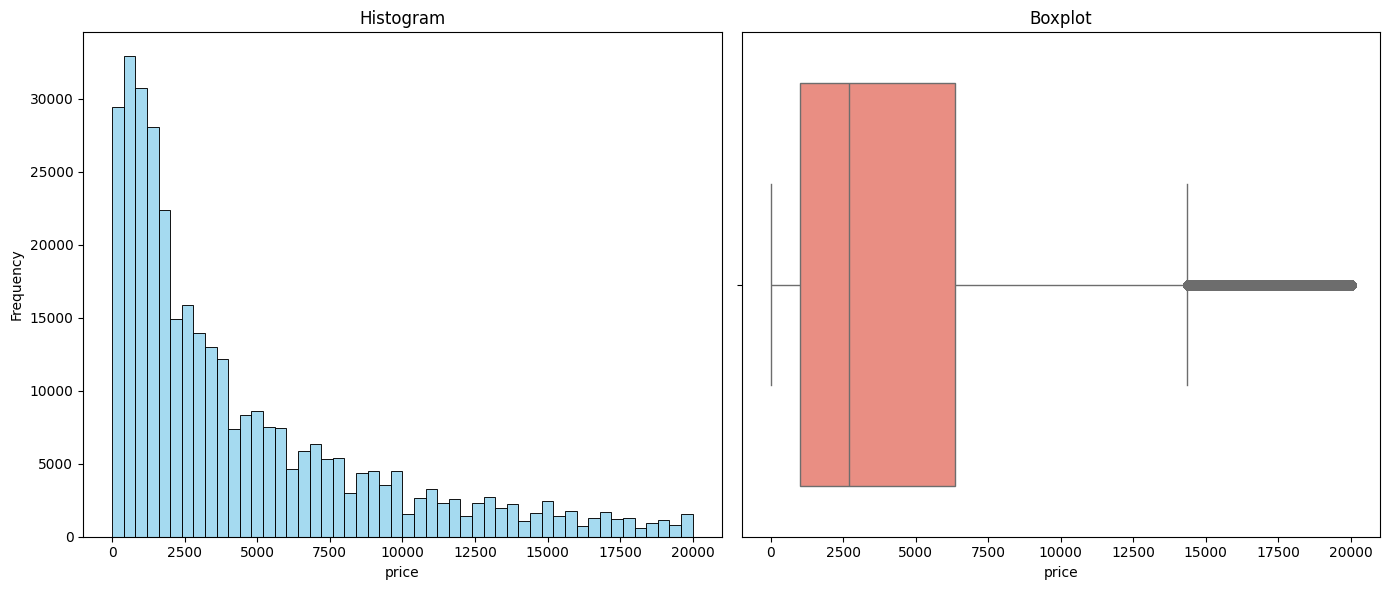

Description of the column registration_year:


,count,mean,std,min,25%,50%,75%,max
0,342535.0,2004.224704,91.1228,1000.0,1999.0,2003.0,2008.0,9999.0


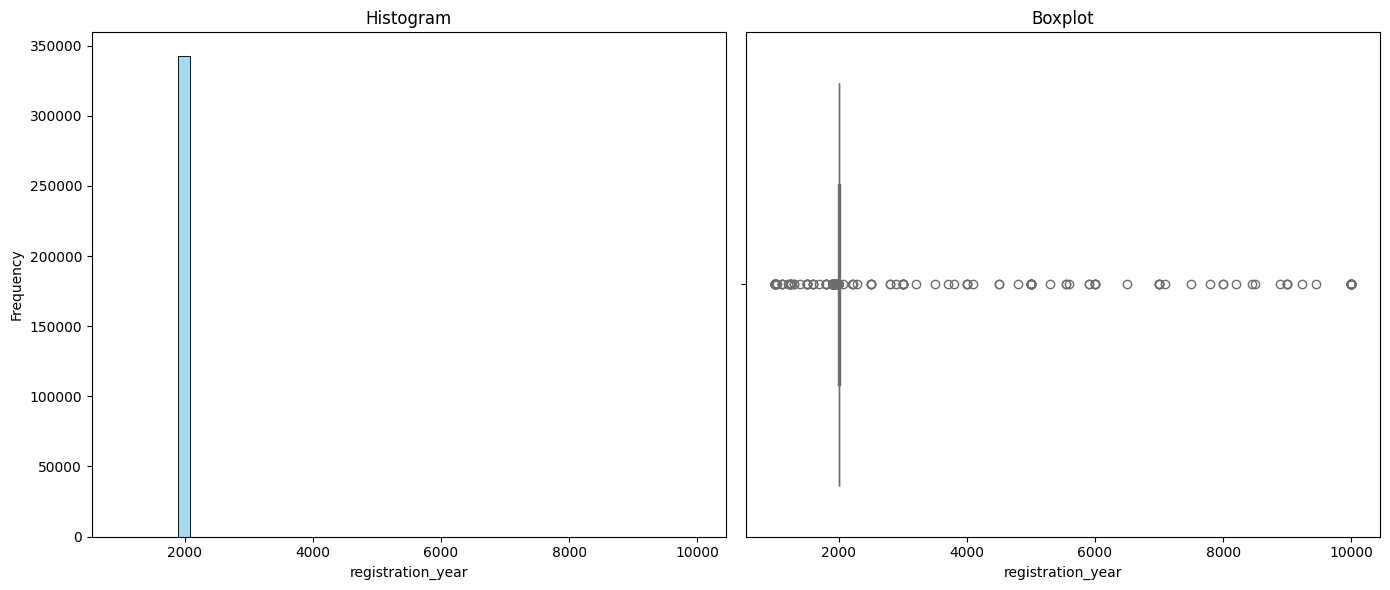

Description of the column power:


,count,mean,std,min,25%,50%,75%,max
0,342535.0,109.971717,191.86381,0.0,68.0,104.0,141.0,20000.0


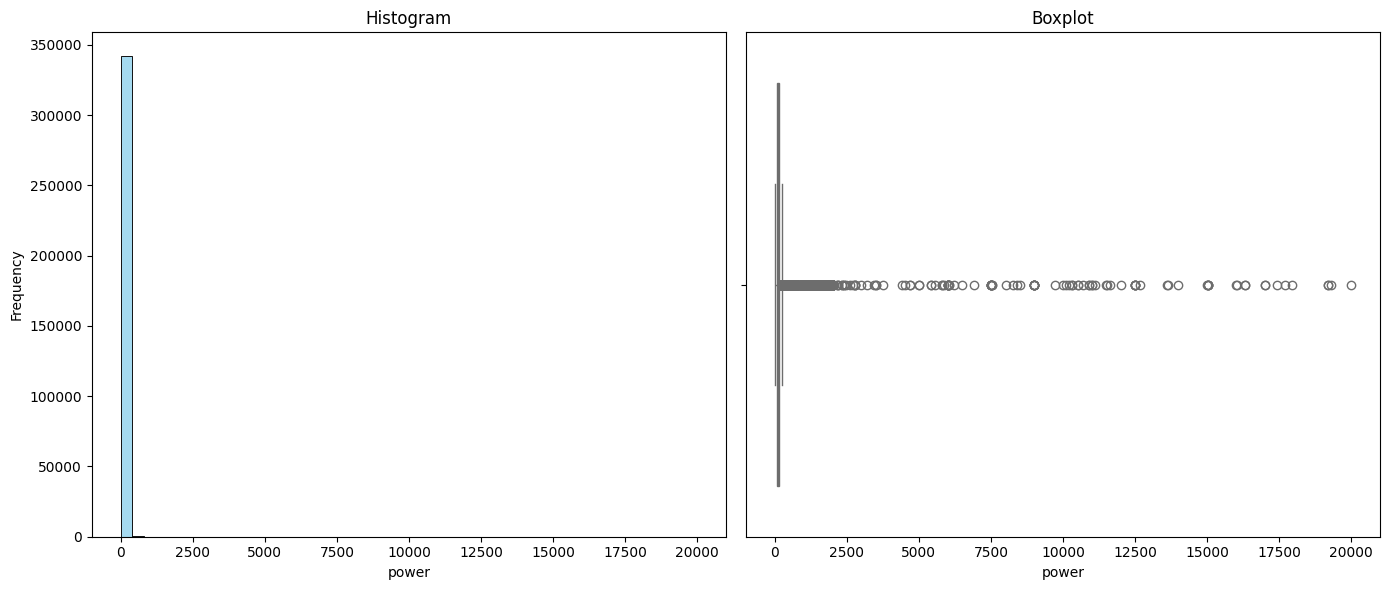

Description of the column kilometer:


,count,mean,std,min,25%,50%,75%,max
0,342535.0,128226.239654,37926.776381,5000.0,125000.0,150000.0,150000.0,150000.0


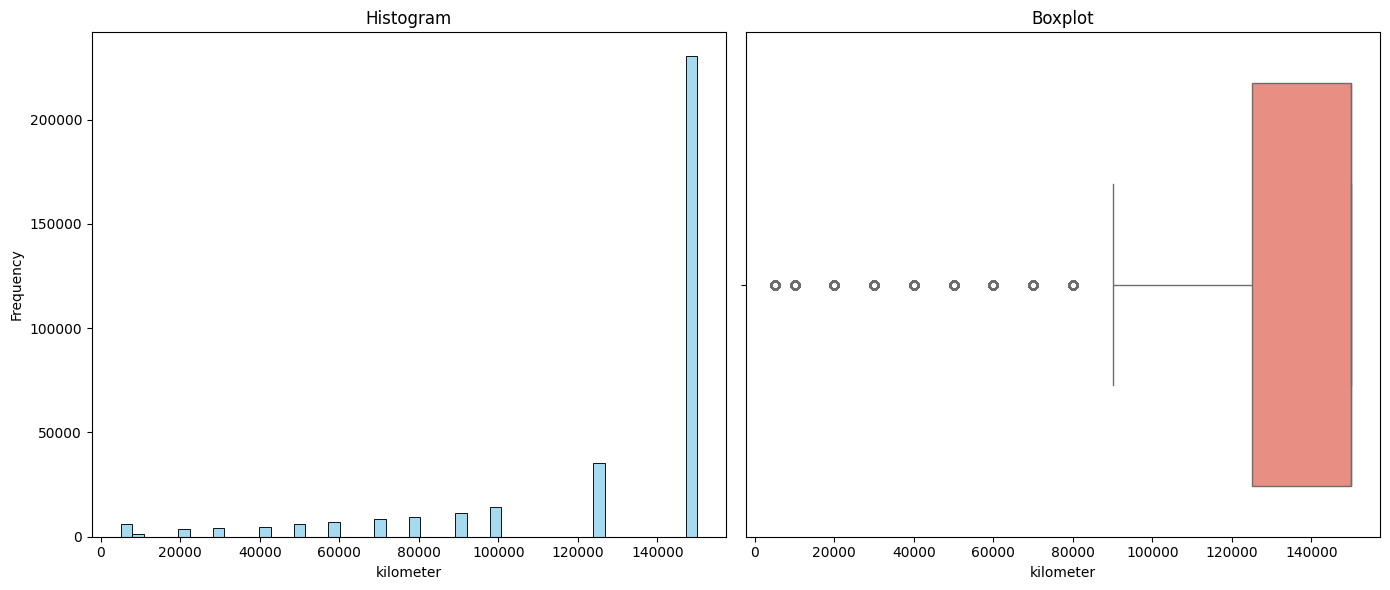

Description of the column registration_month:


,count,mean,std,min,25%,50%,75%,max
0,342535.0,5.699803,3.729032,0.0,3.0,6.0,9.0,12.0


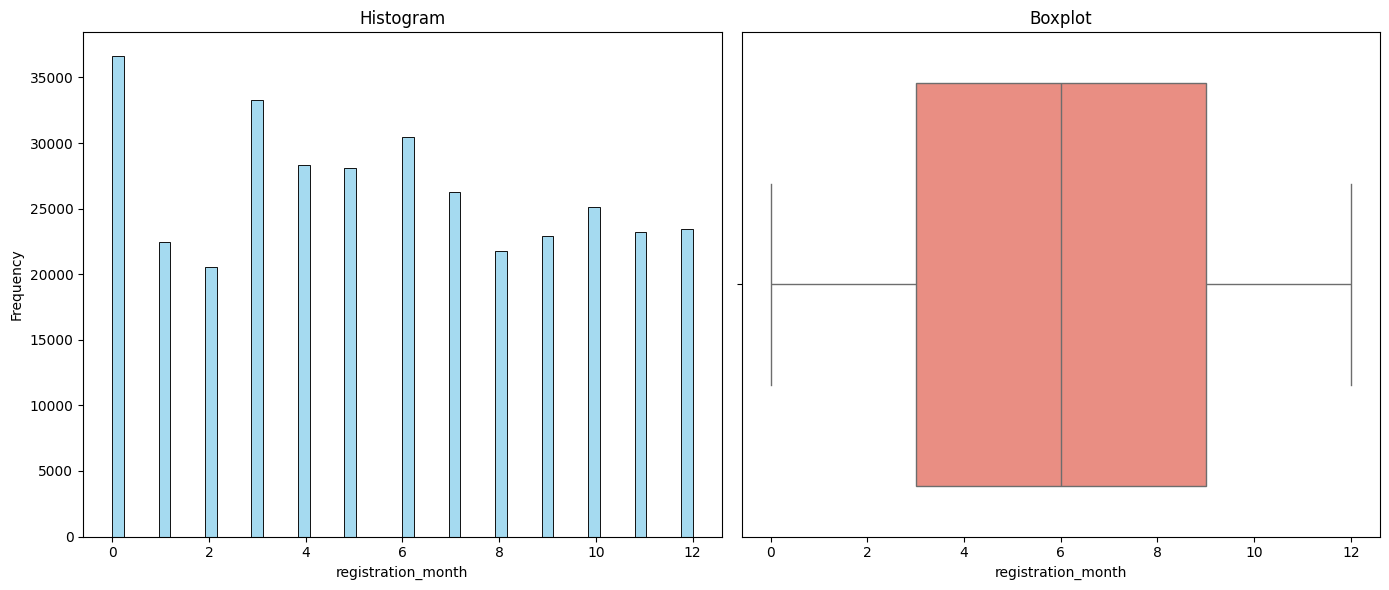

In [11]:
# Оценим количественные признаки 
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    show_box_hist(df[col], show_boxplot=True, bins=50)

Выбросы в колонках:
- power = макисимум 20000 вряд ли отражает реальность
- registration_year  - все что бльше даты загрузки объявления не отражает реальность

## Category columns analysis

Counts and proportions in column vehicle_type:


,Counts,Proportions
vehicle_type,,
sedan,87954,28.77%
small,77208,25.26%
wagon,62700,20.51%
bus,27877,9.12%
convertible,19516,6.38%
coupe,15675,5.13%
suv,11525,3.77%
other,3238,1.06%


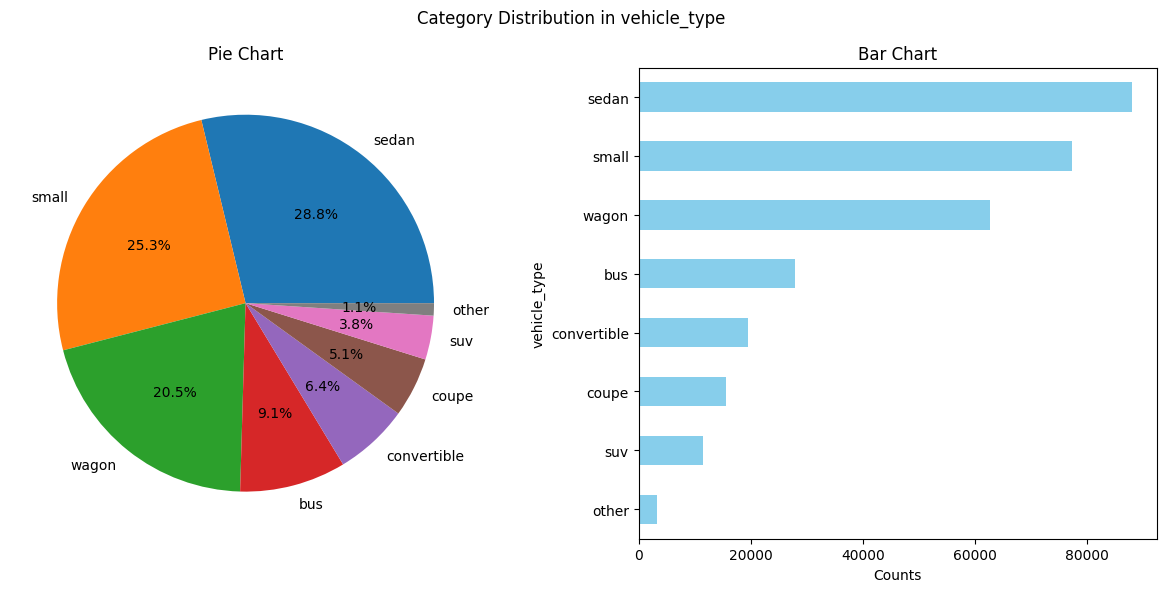

Counts and proportions in column gearbox:


,Counts,Proportions
gearbox,,
manual,259569,80.23%
auto,63957,19.77%


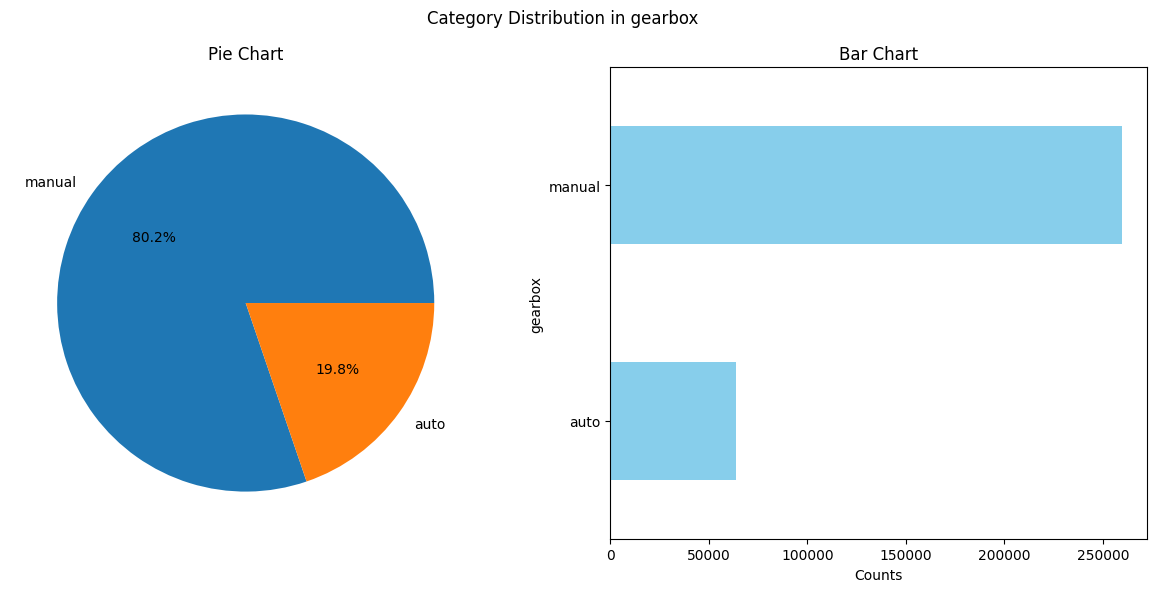

Counts and proportions in column model:


,Counts,Proportions
model,,
golf,28111,8.70%
other,23786,7.36%
3er,18988,5.88%
polo,12649,3.91%
corsa,12133,3.75%
astra,10480,3.24%
passat,9708,3.00%
a4,9437,2.92%
c_klasse,7966,2.46%


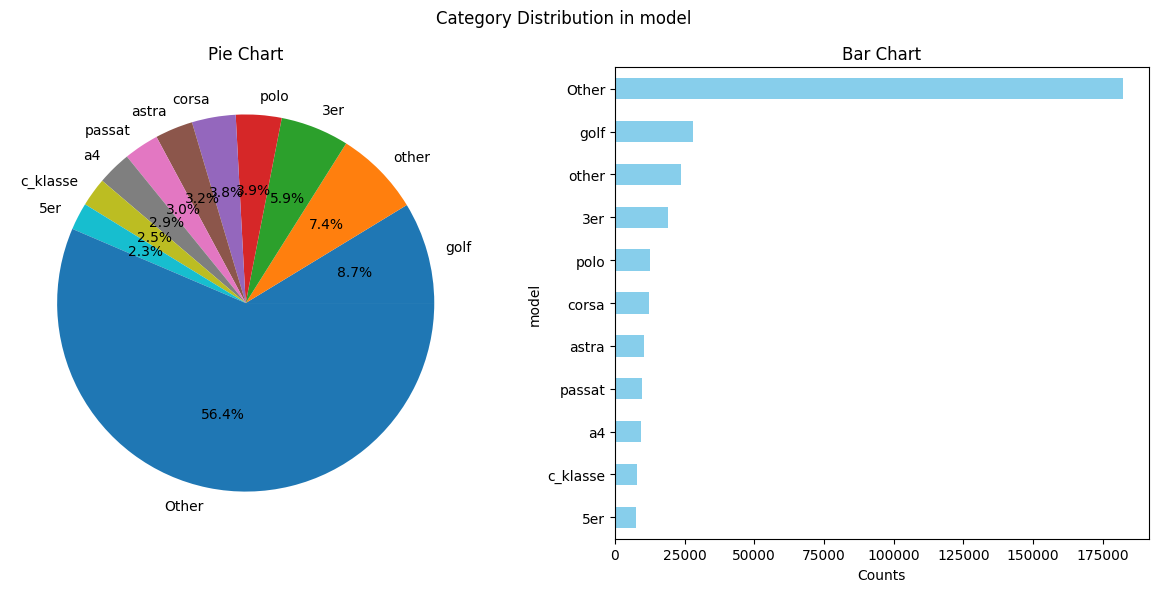

Counts and proportions in column fuel_type:


,Counts,Proportions
fuel_type,,
petrol,209552,67.56%
gasoline,94445,30.45%
lpg,5112,1.65%
cng,555,0.18%
hybrid,228,0.07%
other,201,0.06%
electric,89,0.03%


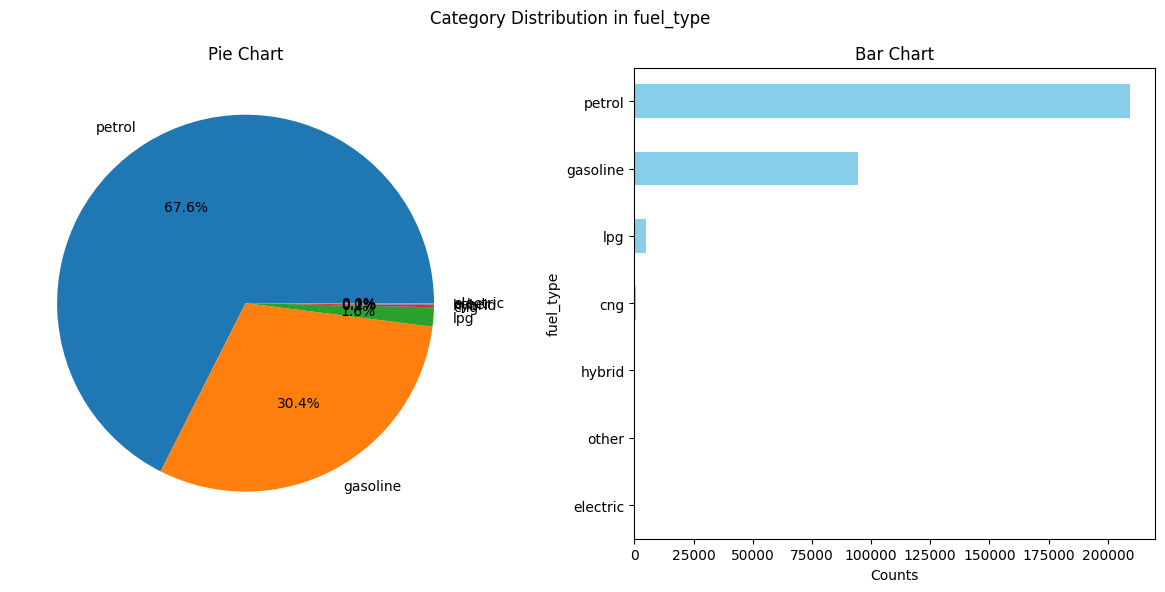

Counts and proportions in column brand:


,Counts,Proportions
brand,,
volkswagen,74183,21.66%
opel,38642,11.28%
bmw,35501,10.36%
mercedes_benz,31051,9.07%
audi,28276,8.25%
ford,24412,7.13%
renault,17469,5.10%
peugeot,10629,3.10%
fiat,9361,2.73%


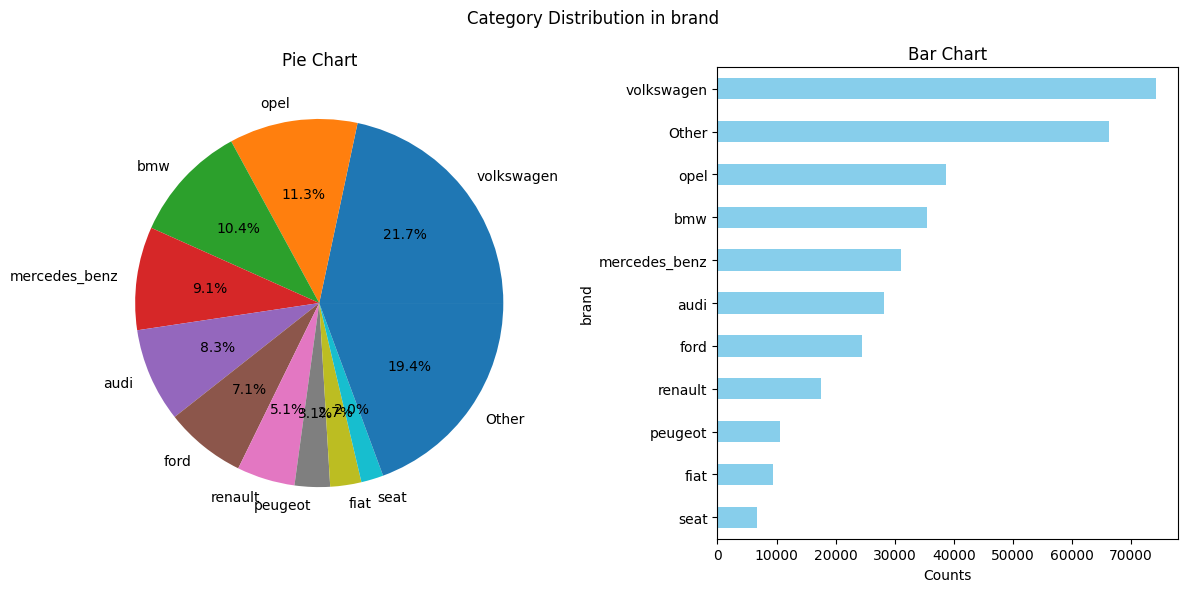

Counts and proportions in column repaired:


,Counts,Proportions
repaired,,
no,237631,87.07%
yes,35273,12.93%


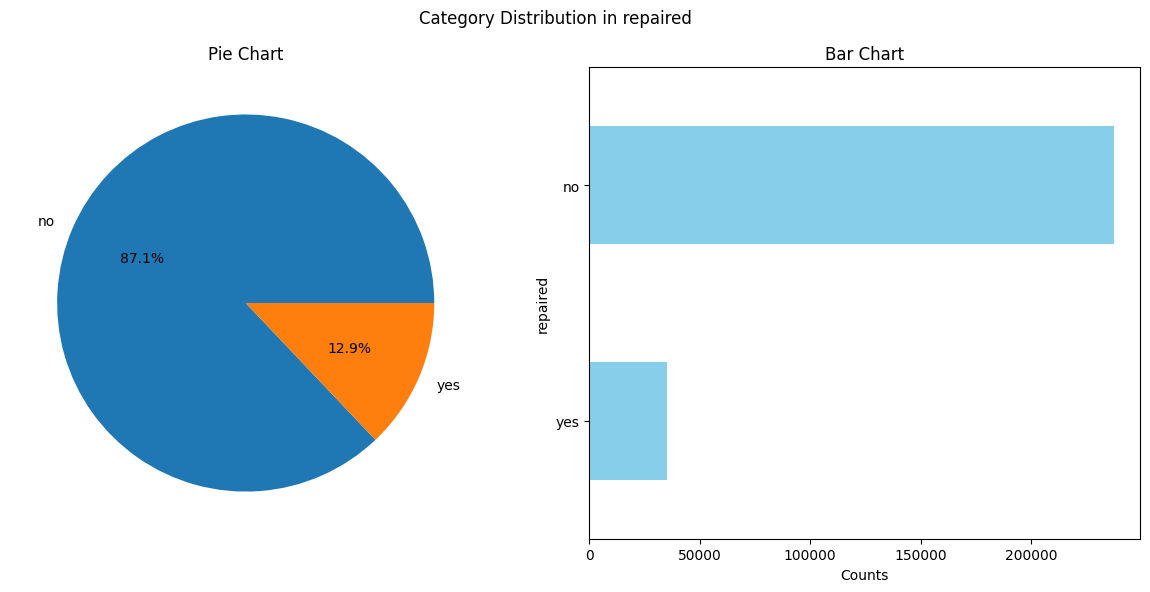

In [12]:
# Оценим качественные признаки 
category_cols = df.select_dtypes(include=['object']).columns

for col in category_cols:
    cat_col_pie(df[col])

In [13]:
len(df['brand'].unique())

40

In [14]:
len(df['model'].unique())

251

In [15]:
df['repaired'].value_counts()

repaired
no     237631
yes     35273
Name: count, dtype: int64

- 40 брендов
- 251 марка
- Неявных дубликатов не заметил (разве что rover land_rover но это вроде разные компании по Вики.)
- Не было в ремонте 87% машин. Непонятно были или нет в ремонте машины что не указаны, вероятно нужно будет удалить строки с этими пропущенными значениями, так как признак важный, а как его восстанавливать неочевидно. 
- petrol и gasoline это вроде одно и тоже, но вероятно под gasoline имеется ввиду diesel - доля таких машин в Европе судя по интернету как раз примено была такой. 

In [16]:
# созданим новые колонки по дате создания объявления
df['created_year'] = df['date_created'].dt.year
df['created_month'] = df['date_created'].dt.month
df.drop(columns='date_created', inplace=True)

In [17]:
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'created_year', 'created_month'],
      dtype='object')

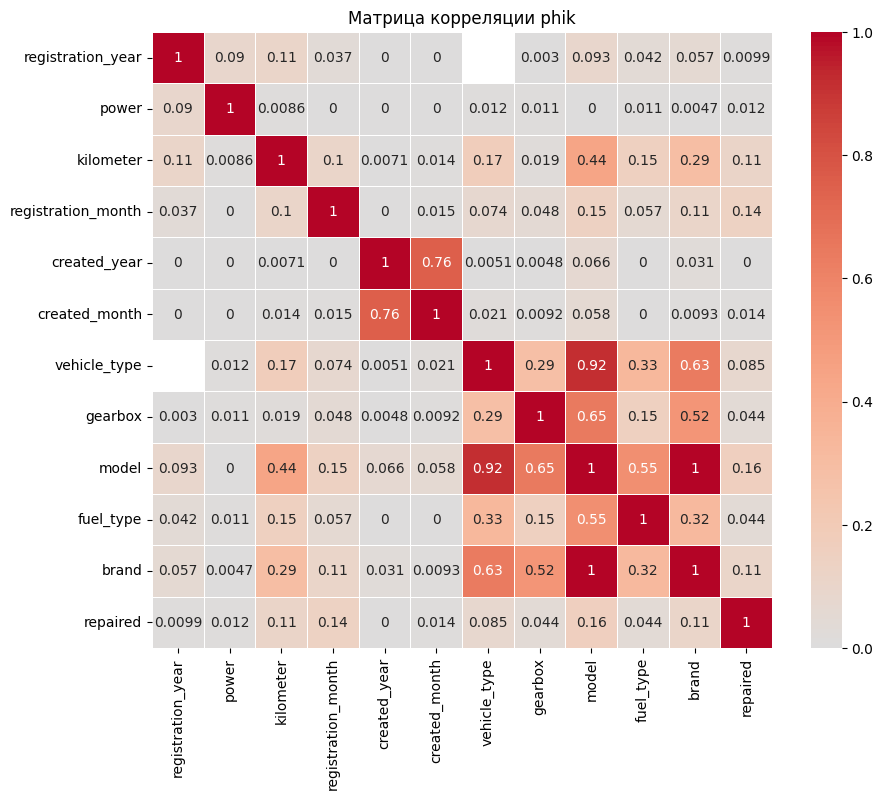

In [18]:
# категориальные и числовые столбцы
categorical_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
numerical_features = ['registration_year', 'power', 'kilometer', 'registration_month', 'created_year', 'created_month']

fig, ax = plt.subplots(figsize=(10,8))         
ax = sns.heatmap(df[numerical_features + categorical_features].phik_matrix(interval_cols = numerical_features), 
                 cmap='coolwarm', center=0, annot=True, linewidth=.5, ax=ax).set_title('Матрица корреляции phik')

Мультколинеарности (phik > 0.99) не наблюдается, это хорошо. Очень сильно коррелирует model и тип кузова - но все же есть отличия и машины могут быть одной модели с разным кузовом. Это важное отличие

# Preprocessing

## Outlier

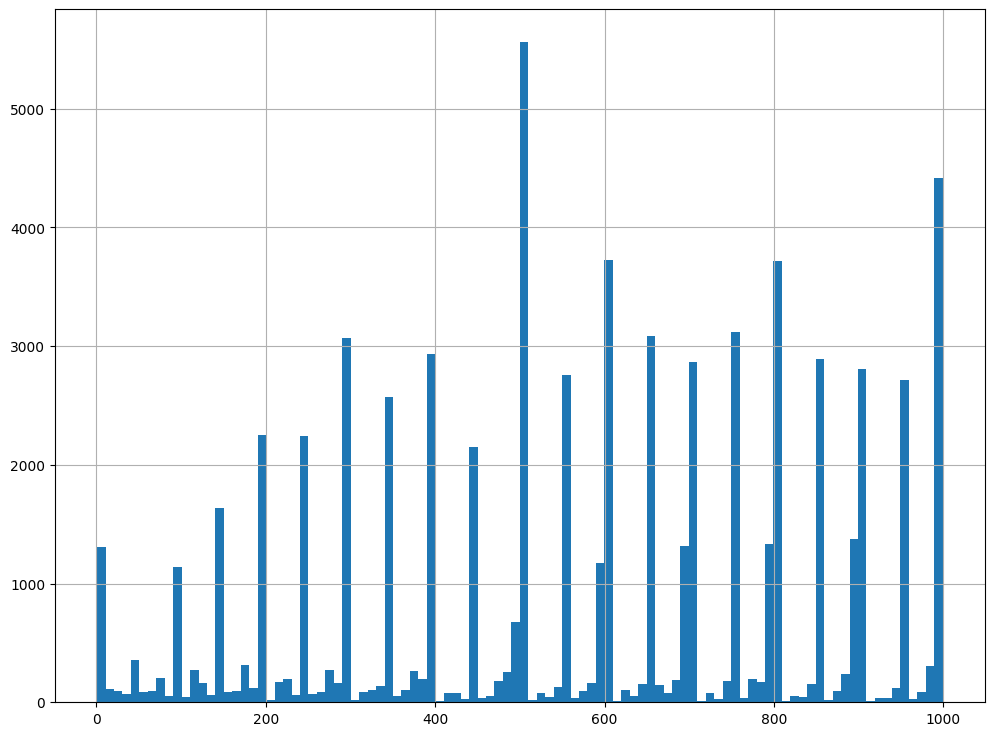

In [19]:
# важно чтобы целевой признак при обучении был логичным. Цена не может быть равной 0 или слишком низкой
ax = df.query('price > 0 & price < 1000')['price'].hist(bins=100, figsize=(12,9))

In [20]:
# удалим из df объявления с ценой 0 Евро
df_filtred = df.copy()
print('До удаления 0 цен', df_filtred.shape)
df_filtred = df_filtred.query('price > 0')
print('После удаления 0 цен', df_filtred.shape)

До удаления 0 цен (342535, 13)
После удаления 0 цен (332089, 13)


Не нулевые низкие цены удалять не стал, так как, а вдург кто-то продает на металалом?

<Axes: >

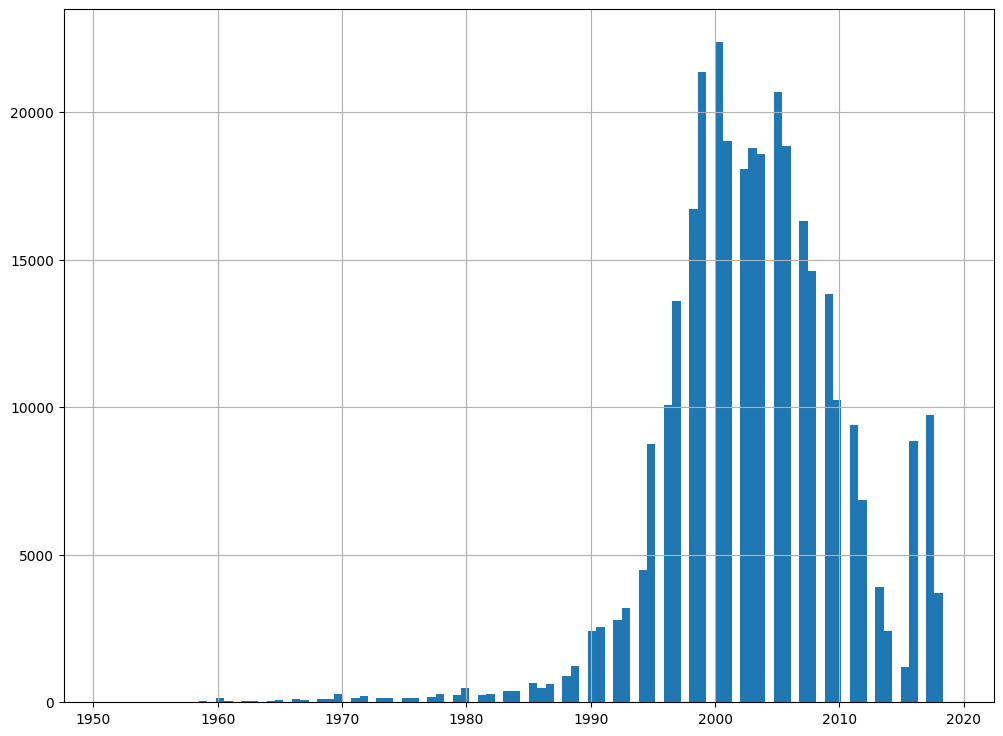

In [21]:
# оставим корректные года регистрации 
df_filtred.query('registration_year > 1950 & registration_year <= 2030')['registration_year'].hist(bins=100, figsize=(12,9))

датасет явно собирася примерно до 2018 года. Так же есть машины страше 1960, это возможно раритеты и ценообразование может быть очень специфичным по таким машинам.

In [22]:
df_filtred.query('registration_year <= 1960')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,created_year,created_month
15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016,3
1928,7000,suv,1945,manual,48,other,150000,2,petrol,volkswagen,no,2016,3
2273,1800,convertible,1925,NaN,0,NaN,5000,1,NaN,sonstige_autos,no,2016,3
3333,10500,sedan,1955,manual,30,other,60000,0,petrol,ford,NaN,2016,3
6977,135,NaN,1910,NaN,0,NaN,5000,0,NaN,opel,NaN,2016,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
351299,5500,bus,1956,manual,37,NaN,60000,4,petrol,sonstige_autos,no,2016,3
351682,11500,NaN,1800,NaN,16,other,5000,6,petrol,fiat,NaN,2016,3
353531,6000,sedan,1937,manual,38,other,5000,0,petrol,mercedes_benz,NaN,2016,3
353961,200,NaN,1910,NaN,0,NaN,5000,0,petrol,sonstige_autos,NaN,2016,3


In [23]:
df_filtred = df_filtred.query('registration_year >= 1960 & registration_year <= 2020')

Судя по [вики](https://en.wikipedia.org/wiki/List_of_production_cars_by_power_output) самый мощный автомобиль это 1715 л.с. Koenigsegg Gemera. И производится он в 2023 году, ранее были менее мощные до 1500 л.с.

In [24]:
df_filtred.query('power >= 1500')['model'].unique()

array(['lupo', 'zafira', 'focus', '5er', 'e_klasse', 'c5', '3er', 'caddy',
       'golf', 'other', 'aygo', 'escort', 'transporter', 'mondeo',
       'fortwo', 'seicento', 'polo', nan, 'c_klasse', 'berlingo', 'omega',
       'sprinter', 'vectra', 'a6', 'astra', 'passat', 'stilo', 'ibiza',
       'megane', 'ceed', '80', '1er', 'octavia', 's_klasse', 'twingo',
       'cooper', 'corsa', '147', 'agila', 'fiesta', 'galaxy', 'a3', 'rav',
       'clk', 'laguna', 'bravo', 'scenic', 'spark', 'a4', 'nubira',
       'kangoo', 'toledo', 'tt', 'up', 'a8', 'touareg', 'clio', 'tiguan',
       'c_max', 'punto', 'a_klasse', 'carisma'], dtype=object)

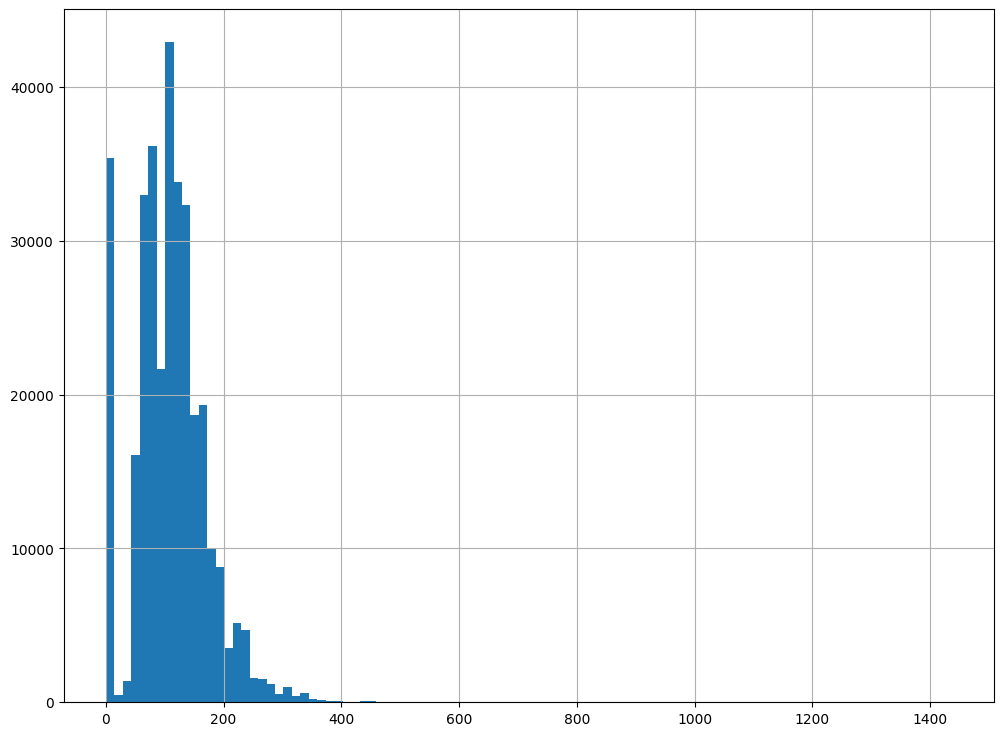

In [25]:
ax = df_filtred.query('power < 1500')['power'].hist(bins=100, figsize=(12,9))

187 строк с обычными вполне брендами. 
Более 500 л.с - очень редкие значения. 
Обнулим высокие значения мошности, а далее заполним NaN значения модой внутри модели. У нас датасет относительно большой, можно конечно и удалить, но на малых я бы делал так

In [26]:
df_filtred.loc[df_filtred['power'] > 500, 'power'] = np.NaN

## Missing values preprocessing

- где нам неизвестно ремонтировалась или нет машина - поставим unknown значения. 
- VehicleType - наиболее часто встречающиеся знаяения внутри Model
- FuelType  - восстановим по моде внутри Model
- Model - нет вижу хорошего способа восстановить - поставим unknown значения. 
- Power - пропущенные знаечния заполним медианой внутри модели
- Gearbox - восстановим по моде внутри Model

In [27]:
# где нам неизвестно 'Repaired' - поставим unknown значения. 
df_filtred['repaired'] = df_filtred['repaired'].fillna('unknown')

In [28]:
# VehicleType - наиболее часто встречающиеся знаяения внутри Model, а где неизвестно 'unknown'
df_filtred['vehicle_type'] = df_filtred['vehicle_type'].fillna(df_filtred
                                         .groupby('model')['vehicle_type']
                                         .transform(lambda x: x.value_counts().idxmax())
                                        )

df_filtred['vehicle_type'] = df_filtred['vehicle_type'].fillna('unknown')

In [29]:
# FuelType - наиболее часто встречающиеся знаяения внутри Model, а где неизвестно 'unknown'
df_filtred['fuel_type'] = df_filtred['fuel_type'].fillna(df_filtred
                                         .groupby('model')['fuel_type']
                                         .transform(lambda x: x.value_counts().idxmax())
                                        )

df_filtred['fuel_type'] = df_filtred['fuel_type'].fillna('unknown')

In [30]:
# пропущенные знаечния заполним медианой внутри модели, а где неизвестно - мдеианой по всем
df_filtred['power'] = df_filtred['power'].fillna(df_filtred
                                                 .groupby('model')['power']
                                                 .transform('median'))

df_filtred['power'] = df_filtred['power'].fillna(df_filtred['power'].median())

In [31]:
print("Количество объявлений с неизвестной model:", len(df_filtred.loc[df_filtred['model'].isna()]))

Количество объявлений с неизвестной model: 17085


Довольно много. Заменим пропущенны Model 'unknown'

In [32]:
df_filtred['model'] = df_filtred['model'].fillna('unknown')

In [33]:

df_filtred['gearbox'] = df_filtred['gearbox'].fillna(df_filtred
                                                     .groupby('model')['gearbox']
                                                     .transform(lambda x: x.value_counts().idxmax())
                                                    )

In [34]:
print(df_filtred.isna().sum())

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
created_year          0
created_month         0
dtype: int64


In [35]:
###  поиск на неявные дубли. 
cat_col = df_filtred.select_dtypes(include=['object']).columns
for col in cat_col:
    print(col, ':', df_filtred[col].unique())

vehicle_type : ['sedan' 'coupe' 'suv' 'small' 'convertible' 'bus' 'wagon' 'other'
 'unknown']
gearbox : ['manual' 'auto']
model : ['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe'
 'passat' 'navara' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'meriva'
 'arosa' 'other' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'one' 'fortwo' '1er' 'b_klasse' 'signum' 'astra' 'a8'
 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort'
 'forester' 'xc_reihe' 'scenic' 'a4' 'ka' 'a1' 'insignia' 'combo' 'focus'
 'tt' 'corsa' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 

In [36]:
df_uni_describe(df_filtred)

Main info:
Number of variables: 13
Number of observations: 331671
Total missing: 0.00%
Total duplicates: 13310
Info of dataframe:
<class 'pandas.core.frame.DataFrame'>
Index: 331671 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               331671 non-null  int64  
 1   vehicle_type        331671 non-null  object 
 2   registration_year   331671 non-null  int64  
 3   gearbox             331671 non-null  object 
 4   power               331671 non-null  float64
 5   model               331671 non-null  object 
 6   kilometer           331671 non-null  int64  
 7   registration_month  331671 non-null  int64  
 8   fuel_type           331671 non-null  object 
 9   brand               331671 non-null  object 
 10  repaired            331671 non-null  object 
 11  created_year        331671 non-null  int32  
 12  created_month       331671 non-null  int32  
dtypes: float6

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,created_year,created_month
0,480,sedan,1993,manual,0.0,golf,150000,0,petrol,volkswagen,unknown,2016,3
1,18300,coupe,2011,manual,190.0,unknown,125000,5,gasoline,audi,yes,2016,3


Descriptive statistics:


,count,mean,std,min,25%,50%,75%,max
price,331671.0,4534.621269,4510.364870,1.0,1200.0,2850.0,6500.0,20000.0
registration_year,331671.0,2003.211646,7.168812,1960.0,1999.0,2003.0,2008.0,2019.0
power,331671.0,107.277858,62.570760,0.0,69.0,105.0,143.0,500.0
kilometer,331671.0,128453.693570,37411.357069,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,331671.0,5.765542,3.700267,0.0,3.0,6.0,9.0,12.0
created_year,331671.0,2015.999931,0.008682,2014.0,2016.0,2016.0,2016.0,2016.0
created_month,331671.0,3.160810,0.375995,1.0,3.0,3.0,3.0,12.0


In [37]:
# убеерм полные дубликаты что у нас повились
df_filtred.drop_duplicates(inplace=True)

In [38]:
df_uni_describe(df_filtred)

Main info:
Number of variables: 13
Number of observations: 318361
Total missing: 0.00%
Total duplicates: 0
Info of dataframe:
<class 'pandas.core.frame.DataFrame'>
Index: 318361 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               318361 non-null  int64  
 1   vehicle_type        318361 non-null  object 
 2   registration_year   318361 non-null  int64  
 3   gearbox             318361 non-null  object 
 4   power               318361 non-null  float64
 5   model               318361 non-null  object 
 6   kilometer           318361 non-null  int64  
 7   registration_month  318361 non-null  int64  
 8   fuel_type           318361 non-null  object 
 9   brand               318361 non-null  object 
 10  repaired            318361 non-null  object 
 11  created_year        318361 non-null  int32  
 12  created_month       318361 non-null  int32  
dtypes: float64(1)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,created_year,created_month
0,480,sedan,1993,manual,0.0,golf,150000,0,petrol,volkswagen,unknown,2016,3
1,18300,coupe,2011,manual,190.0,unknown,125000,5,gasoline,audi,yes,2016,3


Descriptive statistics:


,count,mean,std,min,25%,50%,75%,max
price,318361.0,4539.563392,4518.780158,1.0,1200.0,2850.0,6500.0,20000.0
registration_year,318361.0,2003.196456,7.207081,1960.0,1999.0,2003.0,2008.0,2019.0
power,318361.0,107.396621,62.533647,0.0,69.0,105.0,143.0,500.0
kilometer,318361.0,128341.646747,37487.074839,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,318361.0,5.759619,3.697270,0.0,3.0,6.0,9.0,12.0
created_year,318361.0,2015.999928,0.008861,2014.0,2016.0,2016.0,2016.0,2016.0
created_month,318361.0,3.164684,0.379808,1.0,3.0,3.0,3.0,12.0


# Models training

In [39]:
RANDOM_STATE = 42 # просто понравилось

# Выделим train и тест

X = df_filtred.drop(['price'], axis=1)
y = df_filtred['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=.2,
    random_state=RANDOM_STATE
)

In [65]:
# Создание пустого DataFrame для хранения результатов
results = pd.DataFrame(columns=['Model', 'Training Time', 'Prediction Time', 'RMSE_Training', 'RMSE_Test'])

# функция будет оценивать время выполнения моделей
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, categorical_features=None):
    start_train = time.time()
    if categorical_features:
        model.fit(X_train, y_train, cat_features=categorical_features)
    else:
        model.fit(X_train, y_train)
    end_train = time.time()
    training_time = end_train - start_train

    start_pred = time.time()
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    end_pred = time.time()
    prediction_time = end_pred - start_pred

    rmse_train = round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)
    rmse_test = round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)

    results.loc[len(results)] = [model_name, training_time, prediction_time, rmse_train, rmse_test]

    return results

## Dummy model

In [63]:
# найдем реузльтаты DummyRegression
model_dummy = DummyRegressor(strategy='median')

In [66]:
results = evaluate_model(model_dummy, X_train, X_test, y_train, y_test, 'Dummy model')
results

,Model,Training Time,Prediction Time,RMSE_Training,RMSE_Test
0,Dummy model,0.003986,0.001032,4829.2,4804.68


In [67]:
df_filtred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318361 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               318361 non-null  int64  
 1   vehicle_type        318361 non-null  object 
 2   registration_year   318361 non-null  int64  
 3   gearbox             318361 non-null  object 
 4   power               318361 non-null  float64
 5   model               318361 non-null  object 
 6   kilometer           318361 non-null  int64  
 7   registration_month  318361 non-null  int64  
 8   fuel_type           318361 non-null  object 
 9   brand               318361 non-null  object 
 10  repaired            318361 non-null  object 
 11  created_year        318361 non-null  int32  
 12  created_month       318361 non-null  int32  
dtypes: float64(1), int32(2), int64(4), object(6)
memory usage: 31.6+ MB


In [45]:
# категориальные и числовые столбцы
categorical_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
numerical_features = ['registration_year', 'power', 'kilometer', 'registration_month', 'created_year', 'created_month']

## Linear Regression

In [68]:
# предобработка
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# пайплайн с предобработкой и обучением
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# гиперпараметры
param_grid = {
    'regressor__fit_intercept': [True, False],
}

# Проведение поиска по сетке с кросс-валидацией
lr_grid_search = GridSearchCV(
                    lr_pipeline, 
                    param_grid, 
                    cv=5, 
                    scoring=root_mean_squared_error, 
                    n_jobs=-1)

In [69]:
%%time 
lr_grid_search.fit(X_train, y_train)

c:\Users\l.olipa\practicum\practicum_env\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


CPU times: total: 6.72 s
Wall time: 30.1 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['registration_year',
                                                                          'power',
                                                                          'kilometer',
                                                                          'registration_month',
                                                                          'created_year',
                                                                          'created_month']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['vehicle_type',
                                                                          'gearbox',
                                                                          'model',
                                                                          'fuel_type',
                                                                          'brand',
                                                                          'repaired'])])),
                                       ('regressor', LinearRegression())]),
             n_jobs=-1, param_grid={'regressor__fit_intercept': [True, False]},
             scoring=<function root_mean_squared_error at 0x00000152F573EFC0>)

In [70]:
# Вывод лучших гиперпараметров
print("Лучшие параметры:", lr_grid_search.best_params_)

# Вывод RMSE 
y_pred = lr_grid_search.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print("Корень среднеквадратической ошибки (RMSE):", rmse)

Лучшие параметры: {'regressor__fit_intercept': True}
Корень среднеквадратической ошибки (RMSE): 2762.16124278933


In [71]:
# вытащим лучшую модель
rf_best_model = lr_grid_search.best_estimator_
y_pred = rf_best_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE на тестовых: {final_rmse}")

# сохраним лучшие гиперпараметры
best_params = lr_grid_search.best_params_
best_params

RMSE на тестовых: 2762.16124278933


{'regressor__fit_intercept': True}

In [72]:
best_params = {'regressor__fit_intercept': True}

print(f"Лучшие параметры:: {best_params}")

Лучшие параметры:: {'regressor__fit_intercept': True}


In [74]:
best_regressor_params = {k.split('__')[1]: v for k, v in best_params.items()}

# Создание модели с лучшими параметрами
lr_best_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression(**best_regressor_params))
])

In [75]:
results = evaluate_model(lr_best_model, X_train, X_test, y_train, y_test, 'Linear Regression')
results

,Model,Training Time,Prediction Time,RMSE_Training,RMSE_Test
0,Dummy model,0.003986,0.001032,4829.20,4804.68
1,Linear Regression,4.290099,0.417621,2778.66,2762.16


## Random Forest Regressor

In [76]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Гиперпараметры для поиска
param_distributions = {
    'regressor__n_estimators': st.randint(50, 300),
    'regressor__max_depth': st.randint(5, 100),
    'regressor__min_samples_split': st.randint(2, 20),
    'regressor__min_samples_leaf': st.randint(1, 20),
    'regressor__max_features': ['sqrt', 'log2'],
    'regressor__bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=3,
    random_state=RANDOM_STATE,
    verbose=2
)

In [77]:
random_search.fit(X_train, y_train)

print(f"Лучшие параметры: {random_search.best_params_}")
print(f"Лучший: RMSE: {abs(random_search.best_score_)}")

# вытащим лучшую модель
rf_best_model = random_search.best_estimator_
y_pred = rf_best_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE на тестовых: {final_rmse}")

# сохраним лучшие гиперпараметры
best_params = random_search.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Лучшие параметры: {'regressor__bootstrap': False, 'regressor__max_depth': 68, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 6, 'regressor__n_estimators': 100}
Лучший: RMSE: 1923.0171089141004
RMSE на тестовых: 1865.7620586214518


In [78]:

best_params = {'regressor__bootstrap': False, 
               'regressor__max_depth': 68, 
               'regressor__max_features': 'sqrt', 
               'regressor__min_samples_leaf': 3, 
               'regressor__min_samples_split': 6, 
               'regressor__n_estimators': 100}

print(f"Лучшие параметры:: {best_params}")

Лучшие параметры:: {'regressor__bootstrap': False, 'regressor__max_depth': 68, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 6, 'regressor__n_estimators': 100}


In [79]:
best_regressor_params = {k.split('__')[1]: v for k, v in best_params.items()}

# Создание модели с лучшими параметрами
rf_best_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=RANDOM_STATE, **best_regressor_params))
])

In [80]:
results = evaluate_model(rf_best_model, X_train, X_test, y_train, y_test, 'Random Forest')
results

,Model,Training Time,Prediction Time,RMSE_Training,RMSE_Test
0,Dummy model,0.003986,0.001032,4829.20,4804.68
1,Linear Regression,4.290099,0.417621,2778.66,2762.16
2,Random Forest,629.694576,9.241519,1685.42,1865.76


## LightGBM Regression

In [81]:
# Создание пайплайна
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(random_state=RANDOM_STATE))
])

# Гиперпараметры для поиска
param_distributions = {
    'regressor__num_leaves': st.randint(20, 50),
    'regressor__learning_rate': st.uniform(0.01, 0.1),
    'regressor__n_estimators': st.randint(50, 200),
    'regressor__min_child_samples': st.randint(20, 100),
    'regressor__subsample': st.uniform(0.5, 1.0),
    'regressor__colsample_bytree': st.uniform(0.5, 1.0),
    'regressor__reg_alpha': st.uniform(0.0, 0.1),
    'regressor__reg_lambda': st.uniform(0.0, 0.1)
}

# Создание RandomizedSearchCV
lgbm_random_search = RandomizedSearchCV(
    lgbm_pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=5,
    random_state=42,
    verbose=2
)

In [82]:
# Поиск лучших параметров
start_time = time.time()
lgbm_random_search.fit(X_train, y_train)
elapsed_time = time.time() - start_time
elapsed_time

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\l.olipa\practicum\practicum_env\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
195 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\l.olipa\practicum\practicum_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\l.olipa\practicum\practicum_env\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\l.olipa\practicum\practicum_env\Lib\site-packages\s

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 254688, number of used features: 267
[LightGBM] [Info] Start training from score 4542.042334


205.4396960735321

In [84]:
#  Лучшие гиперпараметры
lgbm_best_params = lgbm_random_search.best_params_
print(f"Лучшие параметры: {lgbm_best_params}")

# Извлечение лучших параметров для регрессора
lgbm_best_regressor_params = {k.split('__')[1]: v for k, v in lgbm_best_params.items()}

lgbm_best_regressor_params

Лучшие параметры: {'regressor__colsample_bytree': 0.8114133093912942, 'regressor__learning_rate': 0.10795105286215086, 'regressor__min_child_samples': 88, 'regressor__n_estimators': 193, 'regressor__num_leaves': 45, 'regressor__reg_alpha': 0.0763364423003911, 'regressor__reg_lambda': 0.08069129770507795, 'regressor__subsample': 0.8463043210894008}


{'colsample_bytree': 0.8114133093912942,
 'learning_rate': 0.10795105286215086,
 'min_child_samples': 88,
 'n_estimators': 193,
 'num_leaves': 45,
 'reg_alpha': 0.0763364423003911,
 'reg_lambda': 0.08069129770507795,
 'subsample': 0.8463043210894008}

In [85]:
lgbm_best_regressor_params = {'colsample_bytree': 0.8114133093912942,
                             'learning_rate': 0.10795105286215086,
                             'min_child_samples': 88,
                             'n_estimators': 193,
                             'num_leaves': 45,
                             'reg_alpha': 0.0763364423003911,
                             'reg_lambda': 0.08069129770507795,
                             'subsample': 0.8463043210894008}

# Создание модели с лучшими параметрами
lgbm_best_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(random_state=RANDOM_STATE, **lgbm_best_regressor_params))
])

In [86]:
results = evaluate_model(lgbm_best_model, X_train, X_test, y_train, y_test, 'LightGBM')
results


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 254688, number of used features: 267
[LightGBM] [Info] Start training from score 4542.042334


,Model,Training Time,Prediction Time,RMSE_Training,RMSE_Test
0,Dummy model,0.003986,0.001032,4829.20,4804.68
1,Linear Regression,4.290099,0.417621,2778.66,2762.16
2,Random Forest,629.694576,9.241519,1685.42,1865.76
3,LightGBM,1.892421,1.473292,1634.02,1671.84


In [59]:
# Предсказание и оценка модели
y_pred = best_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE на тесте: {final_rmse}")
print(f"Time taken to train best model: {elapsed_time_best_model} seconds")

# Отображение времени поиска гиперпараметров и обучения модели
print(f"Time taken to find best parameters: {elapsed_time} seconds")

RMSE на тесте: 1671.8446508615712
Time taken to train best model: 2.478276014328003 seconds
Time taken to find best parameters: 114.25804924964905 seconds


## Catboost Refression

In [60]:
# Индексы категориальных признаков
cat_features_indices = [X.columns.get_loc(col) for col in categorical_features]

# Создание модели CatBoost
cbr_model = CatBoostRegressor(loss_function='RMSE', random_state=RANDOM_STATE, verbose=0)

# Гиперпараметры для поиска
param_distributions = {
    'iterations': [100, 300, 600, 1000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.1, 0.3, 0.4, 0.9],
    'l2_leaf_reg': st.uniform(1, 10),
    'bagging_temperature': st.uniform(0, 1),
    'border_count': st.randint(50, 255)
}

# Создание RandomizedSearchCV
cbr_random_search = RandomizedSearchCV(
    cbr_model,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=5,
    random_state=RANDOM_STATE,
    verbose=2
)


In [61]:
# Поиск лучших параметров
start_time = time.time()
cbr_random_search.fit(X_train, y_train, cat_features=cat_features_indices)
elapsed_time = time.time() - start_time

# Лучшие гиперпараметры
best_params = cbr_random_search.best_params_
print(f"Best parameters: {best_params}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits


KeyboardInterrupt: 

In [ ]:
# Обучение модели с лучшими параметрами
cbr_best_model = CatBoostRegressor(loss_function='RMSE', random_state=RANDOM_STATE, **best_params)

start_time = time.time()
cbr_best_model.fit(X_train, y_train, cat_features=cat_features_indices, verbose=0)
elapsed_time_best_model = time.time() - start_time

# Предсказание и оценка модели
y_pred = best_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE на тесте: {final_rmse}")
print(f"Time taken to train best model: {elapsed_time_best_model} seconds")

# Отображение времени поиска гиперпараметров и обучения модели
print(f"Time taken to find best parameters: {elapsed_time} seconds")